***

# `CSE 152 Section 2`
## `Recap: Geometric Image Formation`

***

Let's get some hands-on experience with perspective projection and rigid transformations. First, we'll take some 3D data and project it onto an image using the equations and representations we've learned. The 3D data will come in the form of a point cloud, which is very intuitively just a bunch of XYZ points. For aesthetics, each point will have an RGB color attached to it too. Following this first projection experiment, we'll try to gain some intuition about what the intrinsic/extrinsic parameters mean by modifying their values. Finally, we'll try rotating a cube (which'll be simpler to deal with than the point cloud).

The point cloud data originates from
```
A Large-Scale Hierarchical Multi-View RGB-D Object Dataset 
Kevin Lai, Liefeng Bo, Xiaofeng Ren, and Dieter Fox 
IEEE International Conference on Robotics and Automation (ICRA), May 2011.
```

<IPython.core.display.Javascript object>


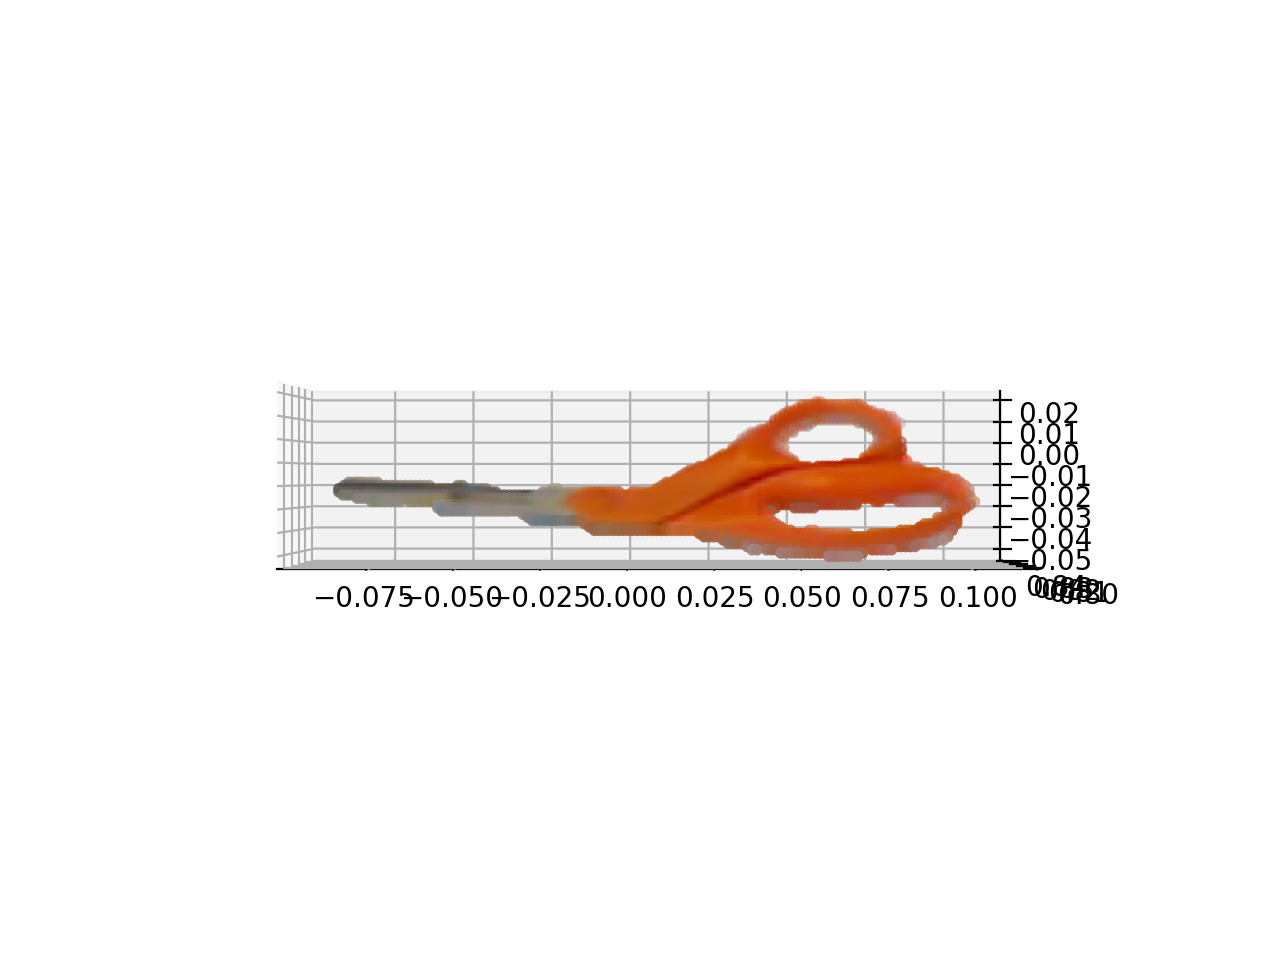

In [1]:
import itertools
import numpy as np
%matplotlib notebook
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 'xyz' : (n, 3)
# 'rgb' : (n, 3)
# 'ixy' : (n, 2)
pc = sio.loadmat('scissors.mat')
xyz = pc['xyz']
rgb = pc['rgb'] / 255.0

fig = plt.figure()
ax = Axes3D(fig)
ax.set_aspect('equal')
ax.view_init(0, -90)
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=10.0, c=rgb)
plt.show()

## 1. Pinhole Perspective Projection

First, let's perform a perspective projection. Right now, we have a point cloud which we'll think of as being in world coordinates. We want to transform it into the camera frame, then project it onto the image. To do so, we'll set up the intrinsic and extrinsic matrices as seen in Lecture 2. Your task is to define those matrices and project the points onto an image using matrix multiplication and homogeneous coordinates. Here are the intrinsics and extrinsics to use:

```
image width:          640
image height:         480
focal length:         575
principal point:      (320, 240)
rigid transformation: 90-degree rotation around x-axis, then 0.01 translation along z-axis
```

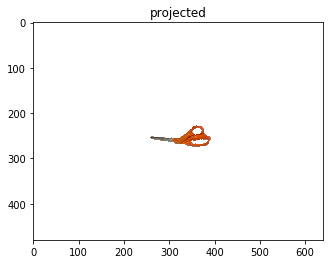

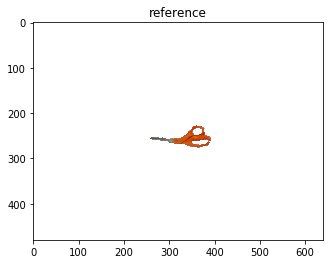

In [2]:
%matplotlib inline

def homogenize(x):
    """Turn inhomogeneous coordinates into homogeneous coordinates.
    If the input is (n, 2), the output will be (n, 3)."""
    return np.hstack((x, np.ones((x.shape[0], 1))))

def dehomogenize(x):
    """Turn homogeneous coordinates into inhomogeneous coordinates.
    If the input is (n, 3), the output will be (n, 2)."""
    return x[:, :-1] / x[:, -1:]

def project(world_xyz, f, cx, cy, R, t):
    """Project world XYZ coordinates onto an image.
    Should take in (x, y, z) inhomogeneous world points in the shape (n, 3)
           and output (x, y) inhomogeneous image points in the shape (n, 2)."""
    # projects points in camera frame to points in image
    intrinsic = np.array([
        [f, 0, cx],
        [0, f, cy],
        [0, 0,  1],
    ])
    # transforms points in world frame to points in camera frame
    # i.e. should have rotation, translation from camera frame to world frame
    extrinsic = np.hstack((R, t))
    projection = intrinsic @ extrinsic
    return dehomogenize(homogenize(world_xyz) @ projection.T)

def visualize(xs, ys, rgb, h, w, title=None):
    """Display projected points with given RGB colors.
    The height and width of the desired image are given as parameters."""
    xs = xs.astype(np.int)
    ys = ys.astype(np.int)
    im = np.ones((h, w, 3))
    im[ys, xs] = rgb
    if title:
        plt.title(title)
    plt.imshow(im); plt.show()

# parameters
w  = 640
h  = 480
f  = 575
cx = 320
cy = 240
R  = np.array([
    [1, 0,  0],
    [0, 0, -1],
    [0, 1,  0],
])
t  = np.array([[0, 0, 0.01]]).T

# projected
ixy = project(xyz, f, cx, cy, R, t)
visualize(ixy[:, 0], ixy[:, 1], rgb, h, w, title='projected')

# reference
visualize(pc['ixy'][:, 0], pc['ixy'][:, 1], rgb, h, w, title='reference')

## 2. Intrinsics

Try multiplying the focal length by 3 and setting the principal point offset to (380, 320). How does this change the image? Why? Think about it geometrically.

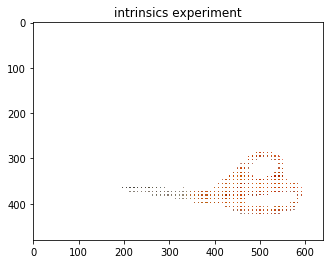

In [3]:
ixy = project(xyz, f * 3, 380, 320, R, t)
visualize(ixy[:, 0], ixy[:, 1], rgb, h, w, title='intrinsics experiment')

## 3. Extrinsics

What if we change the camera/object pose? Let's look at the scissors from farther out, so that they appear smaller. Set the $z$-translation to 1.0.

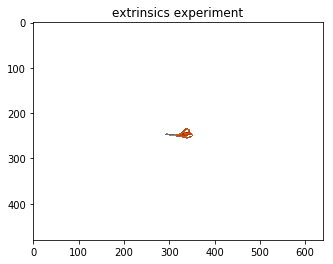

In [4]:
t = np.array([[0, 0, 1.0]]).T
ixy = project(xyz, f, cx, cy, R, t)
visualize(ixy[:, 0], ixy[:, 1], rgb, h, w, title='extrinsics experiment')

## 4. Rotations

Let's apply a 3D rotation to a cube. Here's a cube...

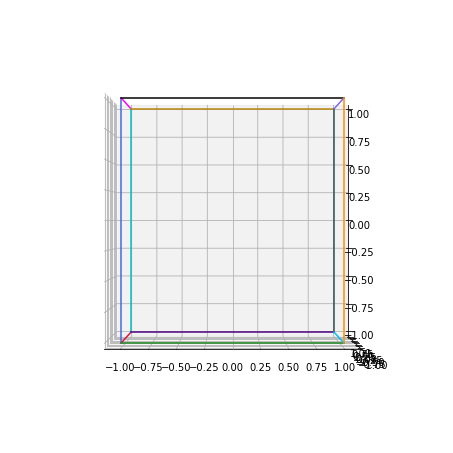

In [5]:
COLORS = [
    'royalblue',
    'crimson',
    'forestgreen',
    'fuchsia',
    'black',
    'c',
    'darkgoldenrod',
    'indigo',
    'darkslategray',
    'deepskyblue',
    'mediumslateblue',
    'darkorange',
]
def plot_cube(vertices, proj_type='persp'):
    fig = plt.figure()
    ax = Axes3D(fig)
    plt.gcf().set_size_inches((6, 6))
    ax.view_init(0, -90)
    ax.set_proj_type(proj_type)
    i = 0
    for v1, v2 in itertools.combinations(vertices, 2):
        if np.isclose(np.linalg.norm(v1 - v2), 2):
            ax.plot3D(*zip(v1, v2), color=COLORS[i])
            i += 1
    plt.show()

vertices = np.array([
    [-1, -1, -1],
    [-1, -1,  1],
    [-1,  1,  1],
    [-1,  1, -1],
    [ 1,  1, -1],
    [ 1,  1,  1],
    [ 1, -1,  1],
    [ 1, -1, -1],
])
plot_cube(vertices)

We can rotate the cube by transforming its `vertices`.

In our current view, the $x$-axis points to the right, the $y$-axis points out of the screen, and the $z$-axis points upward. **Try rotating the cube 45 degrees around the $y$-axis and then $\arccos\left(1 / \sqrt{3}\right)$ [54.74] degrees around the $x$-axis.** From the default frontal viewpoint, the silhouette of the result should be a hexagon.

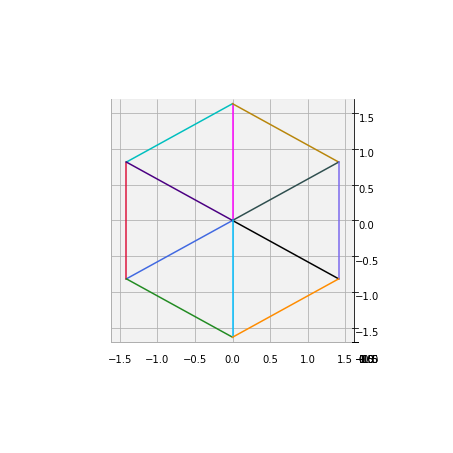

In [6]:
theta = np.radians(45)
y_rotation = np.array([
    [ np.cos(theta), 0, np.sin(theta)],
    [             0, 1,             0],
    [-np.sin(theta), 0, np.cos(theta)],
])
theta = np.radians(54.74)
x_rotation = np.array([
    [1,             0,              0],
    [0, np.cos(theta), -np.sin(theta)],
    [0, np.sin(theta),  np.cos(theta)],
])
rotation = x_rotation @ y_rotation
rotated_vertices = vertices @ rotation.T
plot_cube(rotated_vertices, proj_type='ortho')